## 1. Import Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 2. Load Data

In [8]:
df = pd.read_csv('../../Data/final/lead_time_data.csv')
df.head()

,PODate,ReceivingDate,LeadTimeDays,ItemID,Description,StoreID,Location,Quantity,Week,Month,Day
0,2015-12-22,2016-01-01,10,5255,TGI Fridays Ultimte Mudslide,1,HARDERSFIELD,6,52,12,1
1,2015-12-20,2016-01-01,12,8358,Bacardi 151 Proof,1,HARDERSFIELD,12,51,12,6
2,2015-12-20,2016-01-01,12,4233,Castillo Silver Label Rum,1,HARDERSFIELD,23,51,12,6
3,2015-12-20,2016-01-01,12,3830,Grey Goose L'Orange Vodka,1,HARDERSFIELD,6,51,12,6
4,2015-12-20,2016-01-01,12,4670,Bacardi Dragon Berry Rum,1,HARDERSFIELD,11,51,12,6


## 3. Define Target and Features

In [9]:
#Prediction target
target= 'LeadTimeDays'

#Input features
features= ['ItemID', 'StoreID', 'Quantity', 'Week', 'Month', 'Day']

y= df[target]
x= df[features]

## 4. Splitting Train and Test Data

In [10]:
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.2, random_state= 7)

## 5. Hyperparameter Tuning

In [ ]:
#Set possible values 
hyper_params= {
    #Limits features considered when node split, reduce overfitting
    'max_features' : ['sqrt'],
    #Limits no. levels tree can grow, controls complexity
    'max_depth' : [16, 17],
    #Min no. samples required to split node. Large value = less likely to split
    'min_samples_split' : [2, 5],
    #Min no. samples needed at leaf node. Large value = more general model
    'min_samples_leaf' : [6, 10],
    #No. trees in forest. Usually more trees = better averaging 
    'n_estimators' : [265, 270]
}

#Implement GridSearchCV
rf_est= RandomForestRegressor(random_state=7)

model= GridSearchCV(
    estimator= rf_est,
    param_grid= hyper_params,
    cv=5,
    scoring= 'neg_mean_absolute_error',
    n_jobs= -1
)


## 6. Train Random Forest Model

In [12]:
model.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=7), n_jobs=-1,
             param_grid={'max_depth': [16, 17], 'max_features': ['sqrt'],
                         'min_samples_leaf': [6, 10],
                         'min_samples_split': [2, 5],
                         'n_estimators': [265, 268]},
             scoring='neg_mean_absolute_error')

## 7. Evaluate Model

In [ ]:
#Generate predictions and assign to variable
y_pred = model.predict(x_test)

#Compare test and predicted values to find metrics
mae= mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2= r2_score(y_test, y_pred)

print("Best hyper_params: ", model.best_params_)
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R^2: {r2:.4f}')

Best hyper_params:  {'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 268}
MAE: 1.0800
RMSE: 1.3858
R^2: 0.6134


## 8. Evaluate Metrics

- **Stats Recap**:
    Lead Time Summary Stats:
    * Count   70426 rows
    * Mean        7.98
    * Std         2.23
    * Min         3.00
    * 25%         6.00
    * 50%         8.00
    * 75%        10.00
    * Max        14.00

- **Mean Absolute Error (MAE)**:
    * Value : **1.0800**
    * This model performed well as the predictions are, on average, around 1 day off actual lead time.

- **Root Mean Squared Error (RMSE)**:
    * Value : **1.3858**
    * This metric makes up for what MAE lacks in that RMSE heavily penalizes larger errors and outliers. Its value idicates that are not many large errors as it is close to the value of MAE.

- **R^2**:
    * Value : **0.6134**/**~61%**
    * This model explains around 61% of the variance in the target. This is a solid value considering the difficulty of predicting lead times.



## 9. Actual Vs Predicted Evaluation

### Weekly Average

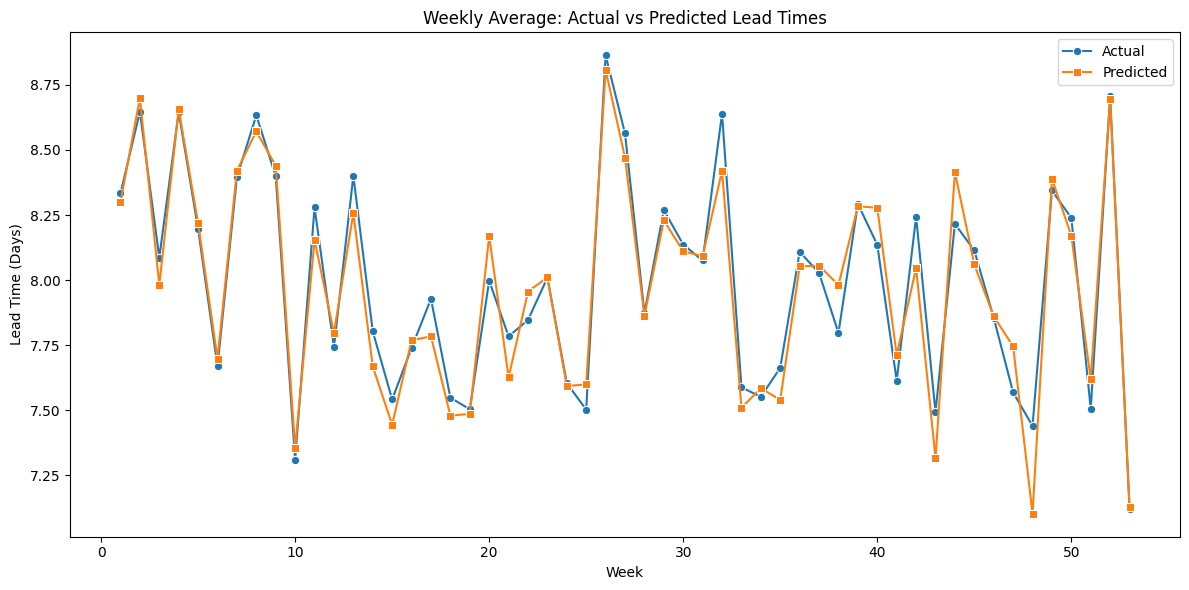

In [17]:
#Create dataframe for plot
df_TBplot = pd.DataFrame({
    'Week': x_test['Week'],
    'Actual': y_test,
    'Predicted': y_pred
})

#Group by weekly average for smoother graph
df_weekly = df_TBplot.groupby('Week').mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='Week', y='Actual', data=df_weekly, marker='o', label='Actual')
sns.lineplot(x='Week', y='Predicted', data=df_weekly, marker='s', label='Predicted')

plt.title('Weekly Average: Actual vs Predicted Lead Times')
plt.xlabel('Week')
plt.ylabel('Lead Time (Days)')
plt.legend()
plt.tight_layout()
plt.savefig('../../artifacts/plots/LeadTimes_WeeklyAve_plot.png')
plt.show()

### Distribution

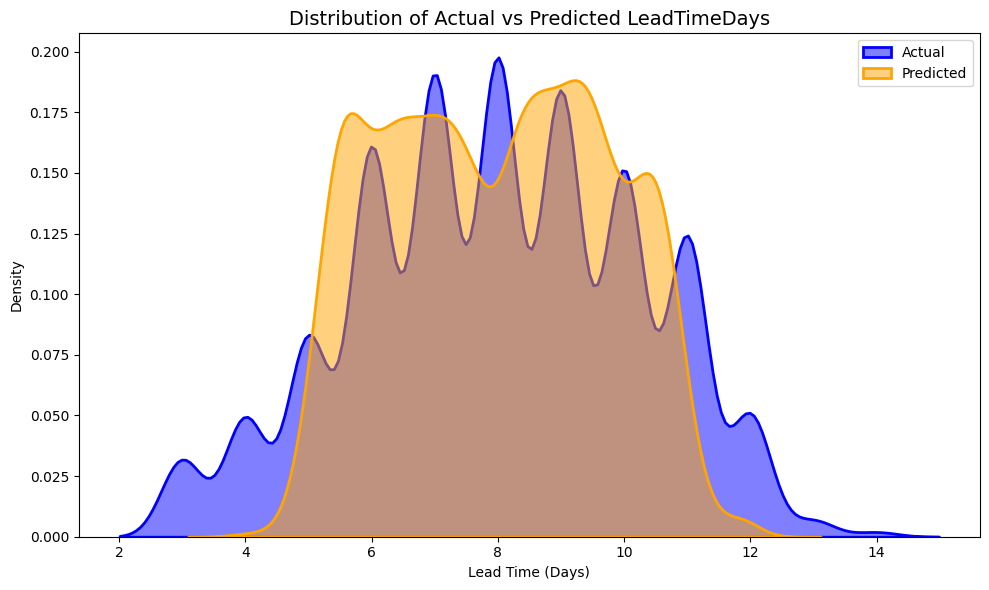

In [18]:
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label='Actual', fill=True, linewidth=2, alpha=0.5, color='blue')
sns.kdeplot(y_pred, label='Predicted', fill=True, linewidth=2, alpha=0.5, color='orange')

plt.title('Distribution of Actual vs Predicted LeadTimeDays', fontsize=14)
plt.xlabel('Lead Time (Days)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.savefig('../../artifacts/plots/LeadTimes_Distribution_plot.png')
plt.show()

## Save Model

In [ ]:
import pickle

# Save the model to a .pkl file using pickle
with open('../../artifacts/models/leadtime_model.pkl', 'wb') as f:
  pickle.dump(model, f)
